In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import sys
import numpy as np
import pandas as pd
import scipy.ndimage
from scipy import interpolate
from scipy import stats

In [3]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [4]:
filename = '../data/garnet_data.csv'

index = np.array( [ 'n_Li', 'E_nn', 'E_site', 'f', 'f_I', 'D_t', 'D_coll', 'n_oct', 'n_tet' ] )

data = pd.read_csv( filename, delim_whitespace = True, names = index, header = None, comment = '#' )

data[ 'H_R' ] = data[ 'f' ] / data[ 'f_I' ]
data[ 'site_ratio' ] = data[ 'n_oct' ] / data[ 'n_tet' ]
data[ 'sigma_eff' ] = data[ 'D_coll' ] * data[ 'n_Li' ]

In [5]:
data.n_Li /= 64.0
data.head()

,n_Li,E_nn,E_site,f,f_I,D_t,D_coll,n_oct,n_tet,H_R,site_ratio,sigma_eff
0,0.015625,0.0,0.0,1.010,1.010,6.352000e-07,6.352000e-07,0.67,0.33,1.000000,2.030303,6.352000e-07
1,0.500000,0.0,0.0,0.948,0.999,5.643000e-07,5.947000e-07,21.33,10.67,0.948949,1.999063,1.903040e-05
2,1.000000,0.0,0.0,0.902,0.995,5.053000e-07,5.577000e-07,42.67,21.33,0.906533,2.000469,3.569280e-05
3,1.500000,0.0,0.0,0.856,1.005,4.495000e-07,5.281000e-07,64.01,31.99,0.851741,2.000938,5.069760e-05
4,2.000000,0.0,0.0,0.808,0.999,3.965000e-07,4.898000e-07,85.34,42.66,0.808809,2.000469,6.269440e-05


In [6]:
def my_plot( subplot, x, y ):
    subplot.plot( x, y, marker = 'o', markeredgewidth=0.0, color='mediumseagreen', clip_on = False )

def setup_figure( subplot ):
    subplot.set_facecolor("w")
    subplot.grid(color='grey', linewidth = 0.3 )
    for s in [ 'top', 'bottom', 'left', 'right' ]:
        subplot.spines[ s ].set_color('grey')
        subplot.spines[ s ].set_linewidth(0.3)
    subplot.tick_params( axis ='both', which = 'both', length = 0, labelsize = 13 )

0.997351707838


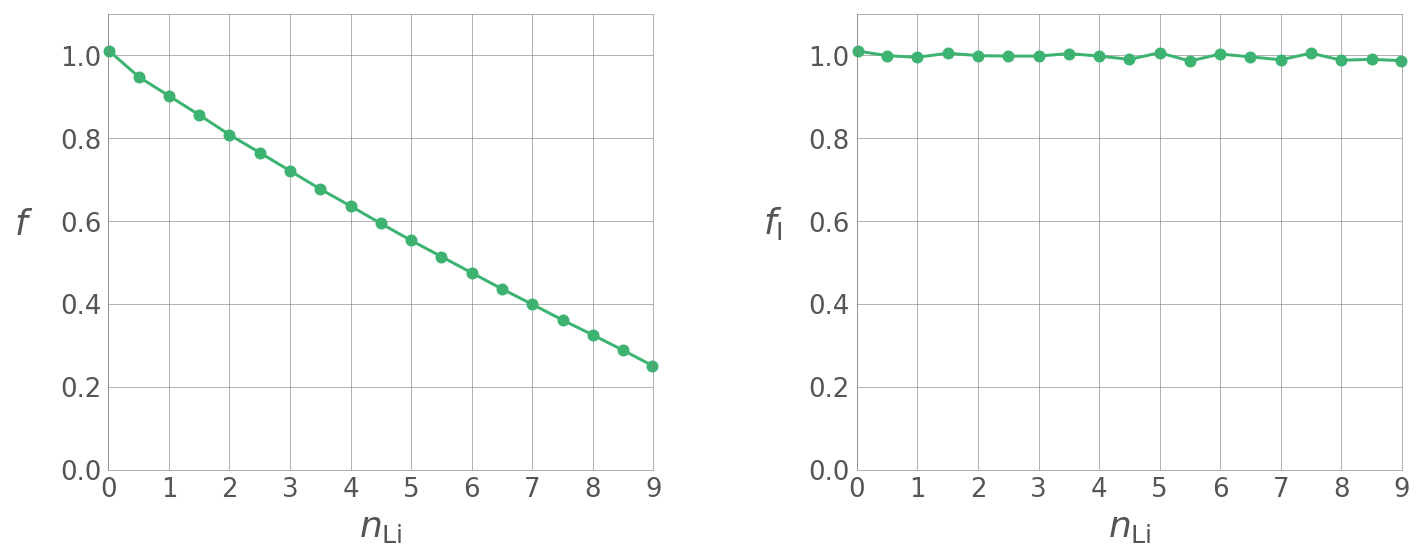

In [7]:
df = data.loc[ ( data.E_nn == 0.0 ) & ( data.E_site == 0.0 ) ]

fig, axs = plt.subplots(1,2, figsize=(10, 4))

setup_figure( axs[0] )
setup_figure( axs[1] )

my_plot( axs[0], df.n_Li, df.f )
axs[0].set_xlabel(r'$n_\mathrm{Li}$', fontsize = 18 )
axs[0].set_ylabel(r'$f$', rotation = 0, labelpad = 18, fontsize = 18 )
axs[0].set_xlim([0,9.0])
axs[0].set_ylim([0.0,1.1])
axs[0].set_xticks(range(10))

my_plot( axs[1], df.n_Li, df.f_I)
axs[1].set_xlabel(r'$n_\mathrm{Li}$', fontsize = 18 )
axs[1].set_ylabel(r'$f_\mathrm{I}$', rotation = 0, labelpad = 18, fontsize = 18 )
axs[1].set_xlim([0,9.0])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xticks(range(10))

plt.tight_layout( w_pad=5 )

fig.savefig( filename = 'volume_exclusion_f_fI.pdf' )

print( stats.linregress( df.n_Li/9, df.f ).rvalue**2 )

In [8]:
def sub_plot( ax, df, x, y, x_range, y_range, log_plot=False ):
    df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
    ax.set_xlim( x_range )
    ax.set_ylim( y_range )
    ax.set_xticks(range(10))
    if not df.empty:
        if not log_plot:
            df.plot( x=x, y=y, ax=ax, legend=None )
        else:
            df.plot( x=x, y=y, ax=ax, legend=None, logy=True,  clip_on=False, zorder=100 )
        ax.set_xlabel('')

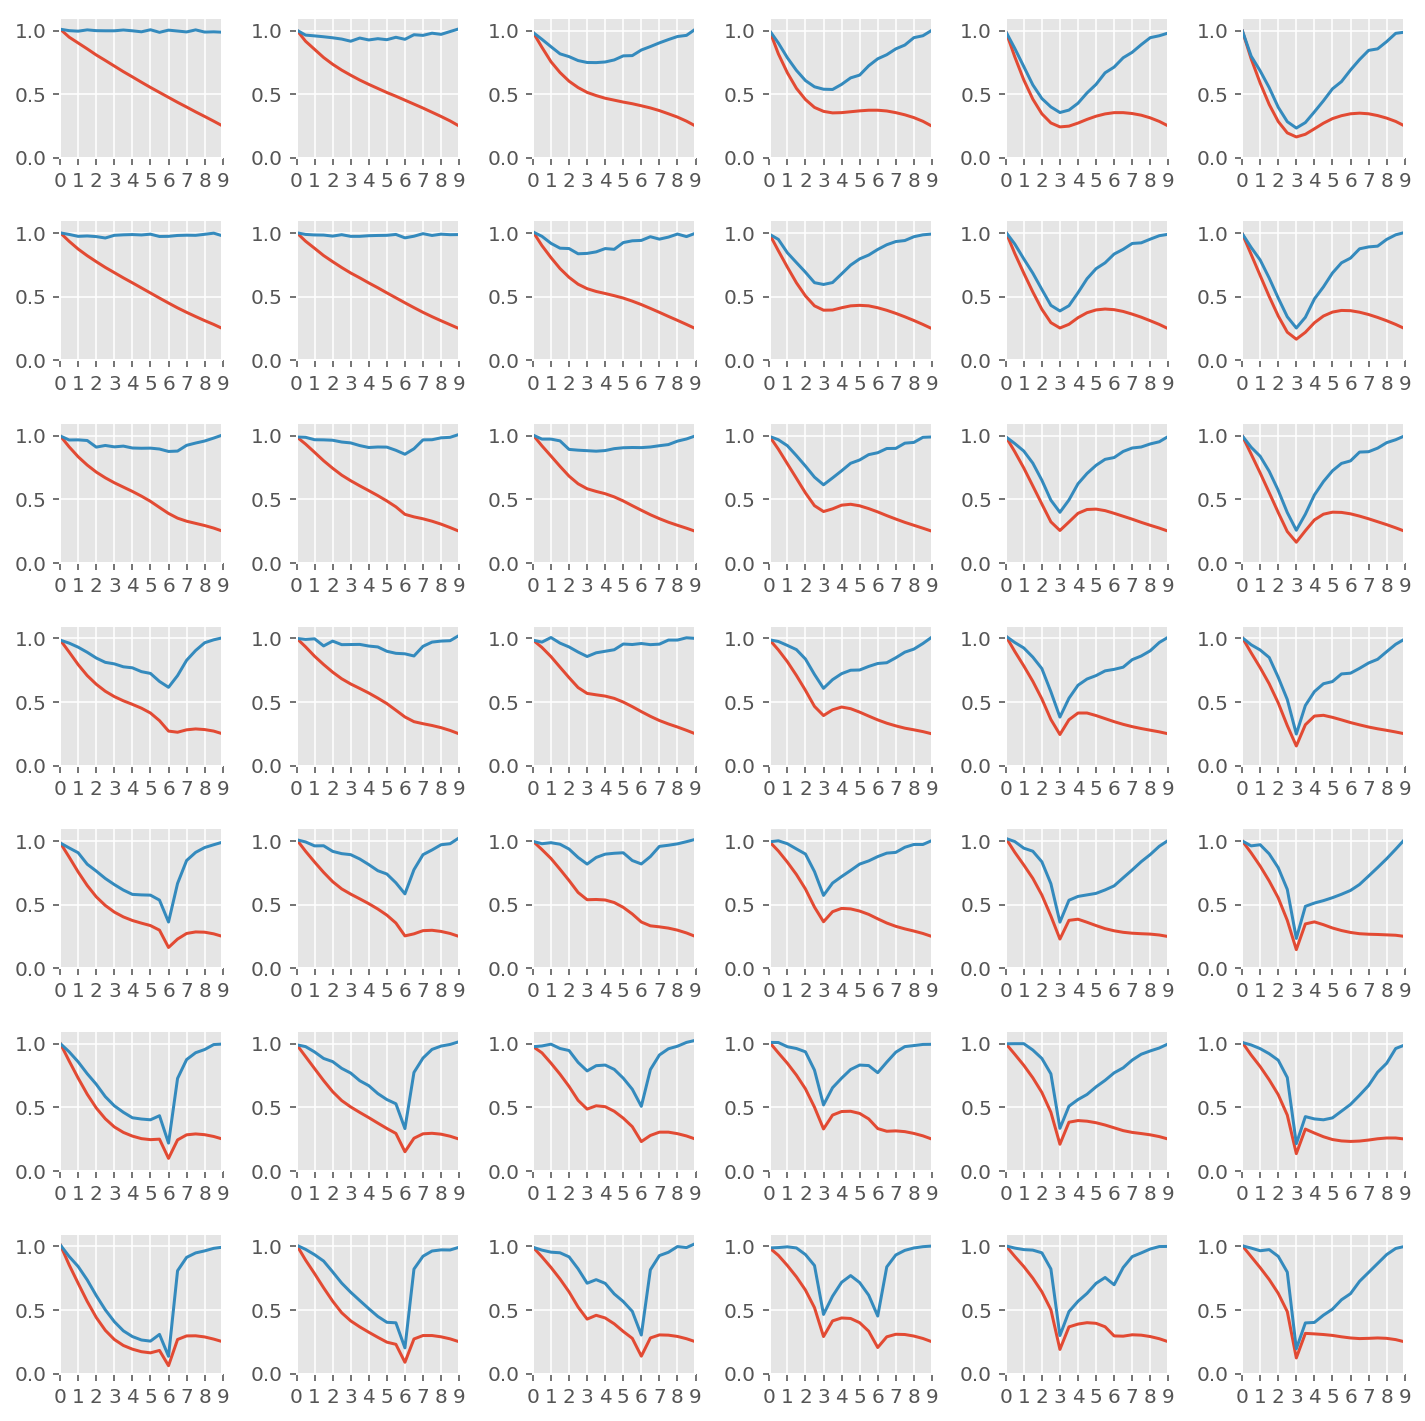

In [9]:
nn_energies = [ 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0 ] 
site_energies = [ 0.0, 1.0, 2.0, 3.0, 4.0, 5.0 ]

fig, axes = plt.subplots(nrows=len(nn_energies), ncols=len(site_energies), figsize = (10, 10))
for i, E_nn in enumerate( nn_energies ):
    for j, E_site in enumerate( site_energies ):
        df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
        sub_plot( axes[i, j], df, x='n_Li', y=[ 'f', 'f_I' ], x_range=[0, 9.0], y_range=[0.0, 1.1] )
    
fig.tight_layout()
fig.savefig( filename = 'correlation_miniplots.pdf' )

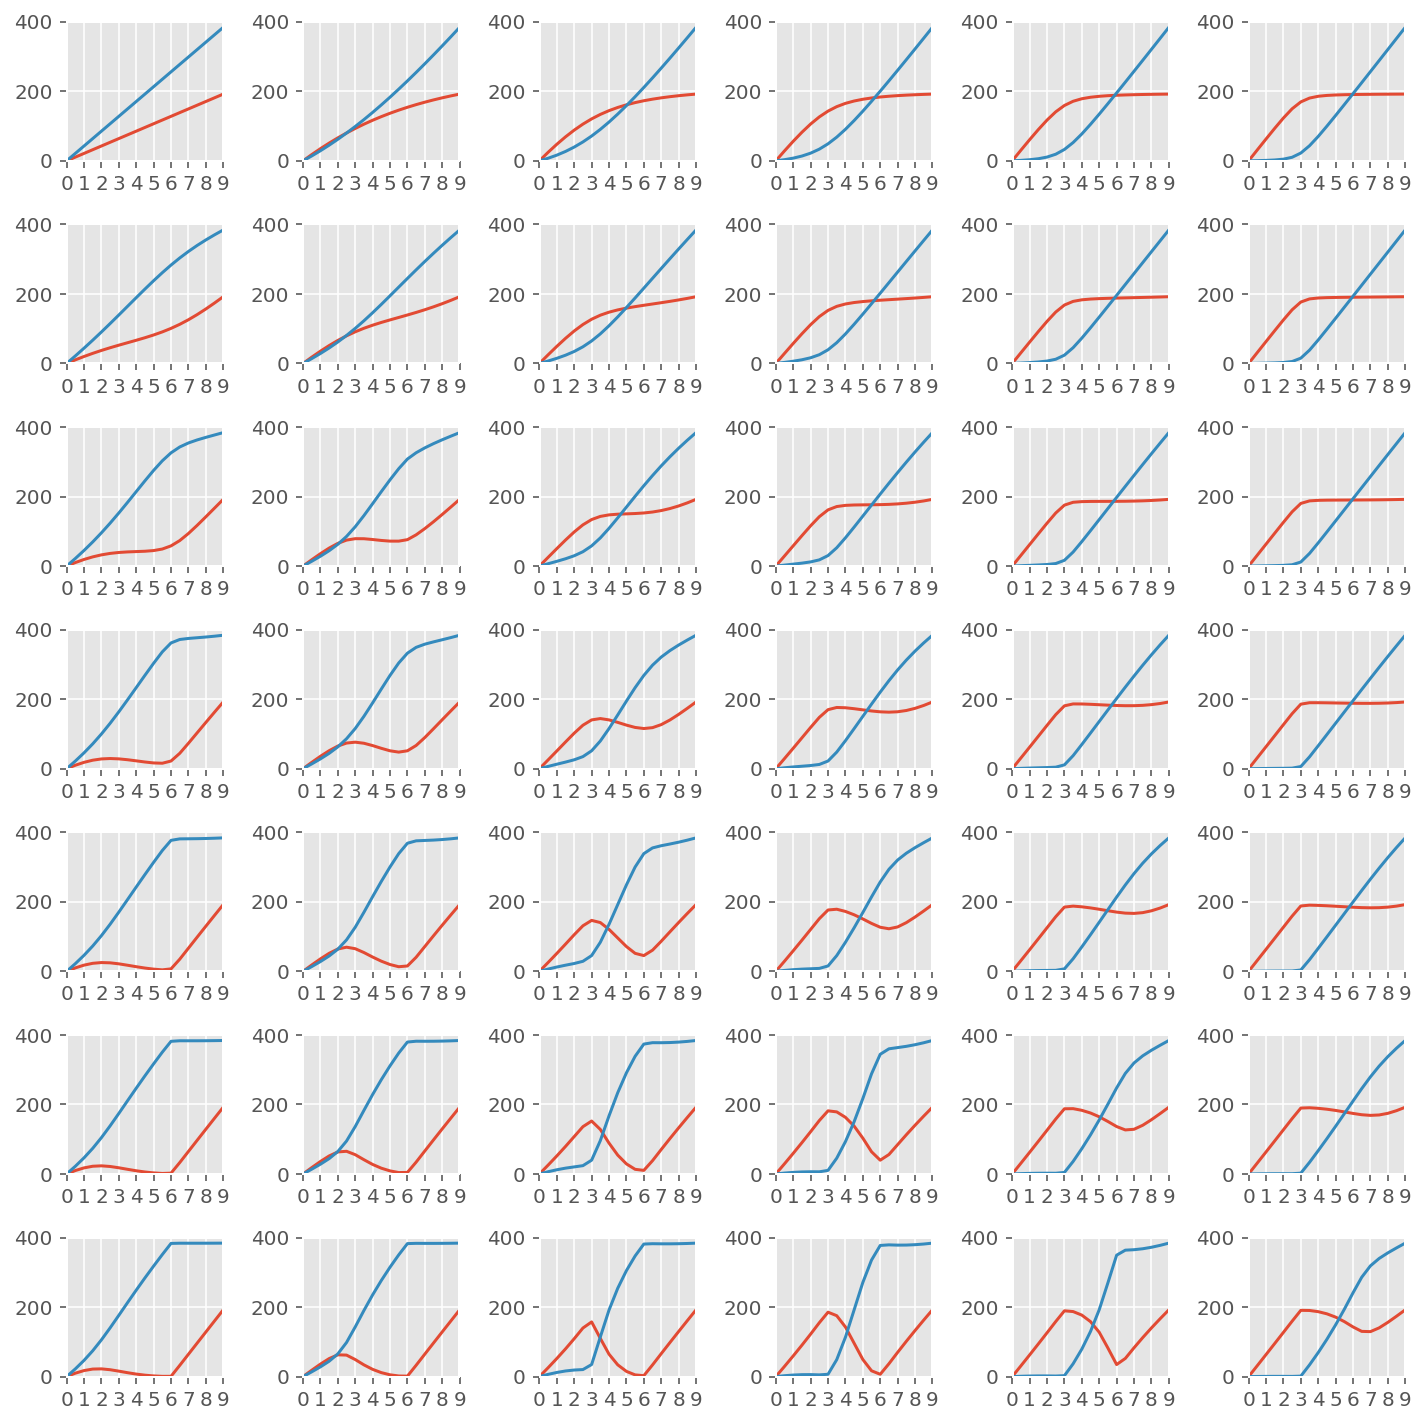

In [10]:
fig, axes = plt.subplots(nrows=len(nn_energies), ncols=len(site_energies), figsize = (10, 10))
for i, E_nn in enumerate( nn_energies ):
    for j, E_site in enumerate( site_energies ):
        df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
        sub_plot( axes[i, j], df, x='n_Li', y=['n_tet', 'n_oct'], x_range=[0, 9.0], y_range=[0,400] )
    
fig.tight_layout()
fig.savefig( filename = 'site_occupation_miniplots.pdf' )

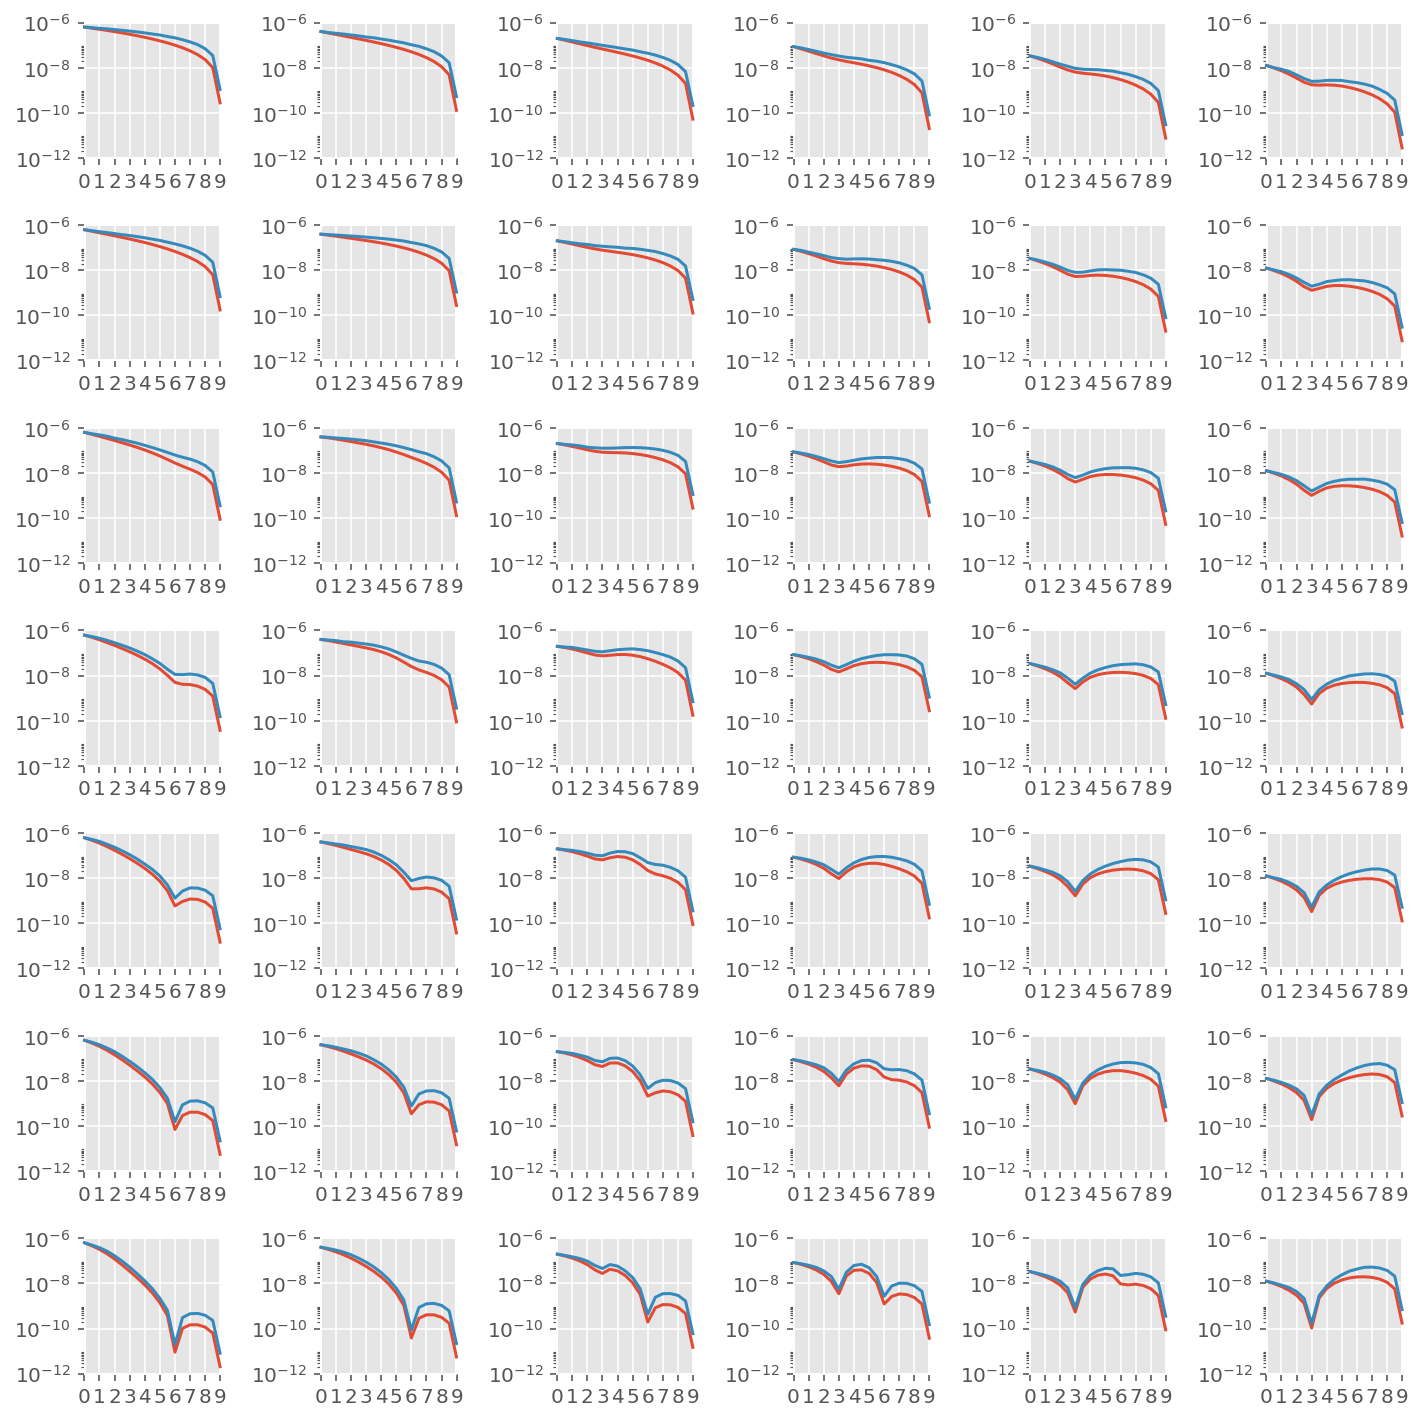

In [11]:
fig, axes = plt.subplots(nrows=len(nn_energies), ncols=len(site_energies), figsize = (10, 10))
for i, E_nn in enumerate( nn_energies ):
    for j, E_site in enumerate( site_energies ):
        df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
        sub_plot( axes[i, j], df, x='n_Li', y=['D_t', 'D_coll'], x_range=[0,9], y_range=[1e-12,1e-06], log_plot=True )
    
fig.tight_layout()
fig.savefig( filename = 'diffusion_miniplots.pdf' )

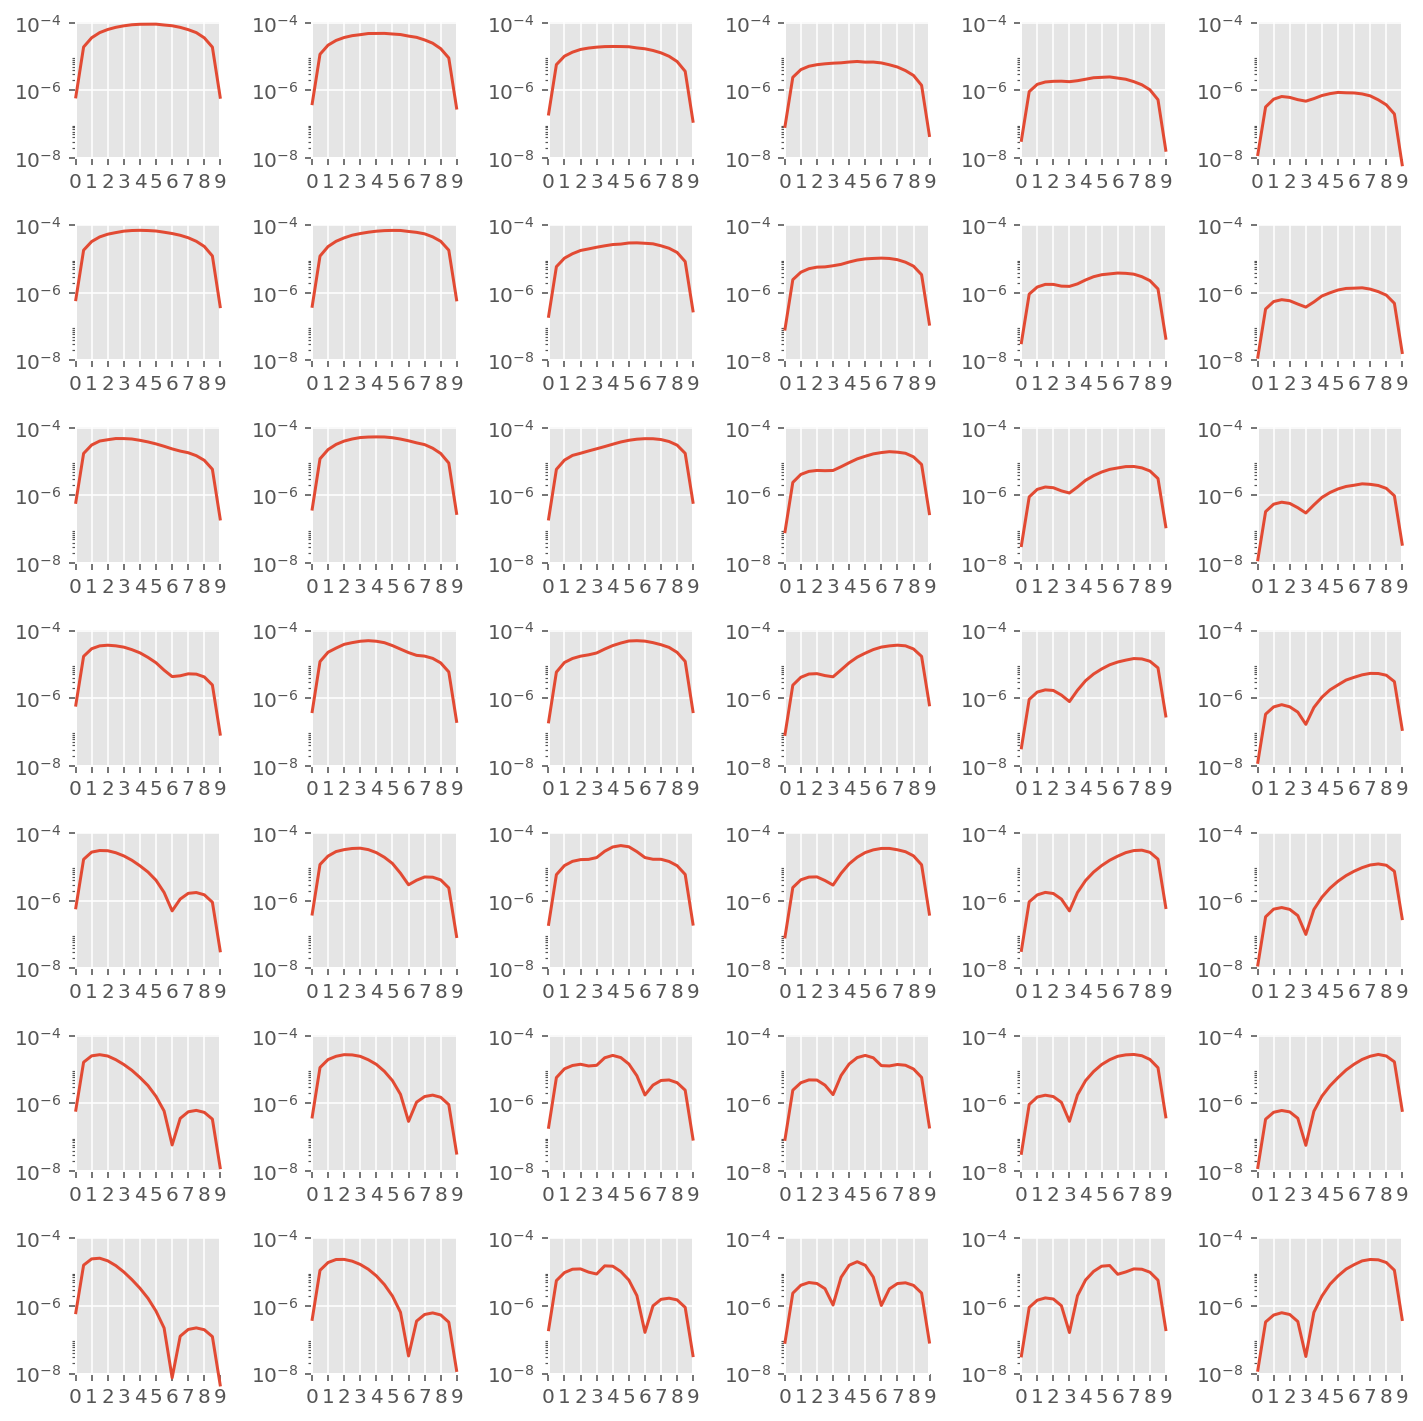

In [12]:
fig, axes = plt.subplots(nrows=len(nn_energies), ncols=len(site_energies), figsize = (10, 10))
for i, E_nn in enumerate( nn_energies ):
    for j, E_site in enumerate( site_energies ):
        df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
        sub_plot( axes[i, j], df, x='n_Li', y='sigma_eff', x_range=[0,9], y_range=[1e-8,1.1e-4], log_plot=True )
    
fig.tight_layout()
fig.savefig( filename = 'conductivity_miniplots.pdf' )

In [13]:
plt.close('all')

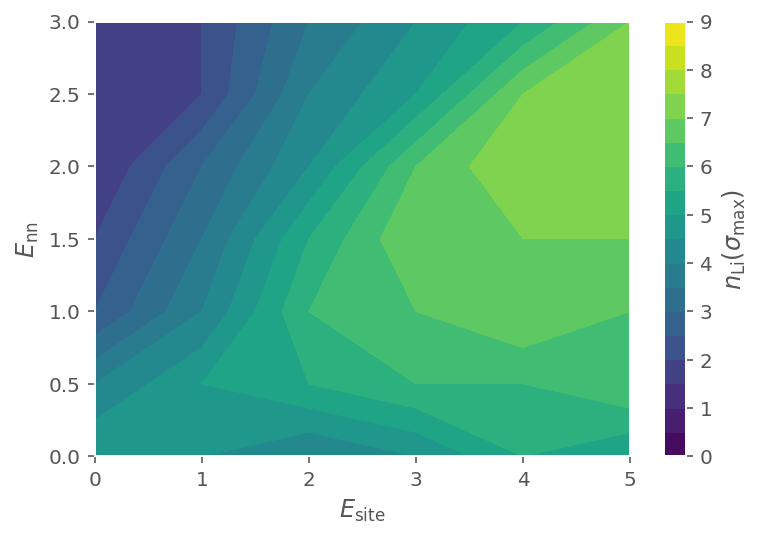

In [14]:
def func( group ):
    return group[ group.sigma_eff == group.sigma_eff.max() ]

ndata_pd = data.groupby( [ 'E_nn', 'E_site' ] ).apply( func ).reset_index( drop = True )
ndata_pd = ndata_pd.sort_values( by = 'E_nn', ascending = False ).pivot( 'E_nn', 'E_site', 'n_Li' )
fig = plt.figure()
ax = fig.add_subplot(111)

ndata = np.nan_to_num( np.array( ndata_pd ) )
# ndata = scipy.ndimage.zoom( ndata, 3)

X = np.linspace( 0, 5.0, 6 )
Y = np.linspace( 0, 3.0, 7 )
Z = ndata
levels = np.linspace( 0.0, 9.0, 19 )

x,y=np.meshgrid(X, Y)
ax.set_xlabel( r'$E_\mathrm{site}$' )
ax.set_ylabel( r'$E_\mathrm{nn}$' )

cs = plt.contourf(x, y, Z, interpolation = 'bicubic', levels = levels, cmap = 'viridis' )

cbar = plt.colorbar( cs )
cbar.ax.set_ylabel( r'$n_\mathrm{Li}(\sigma_\mathrm{max}$)')

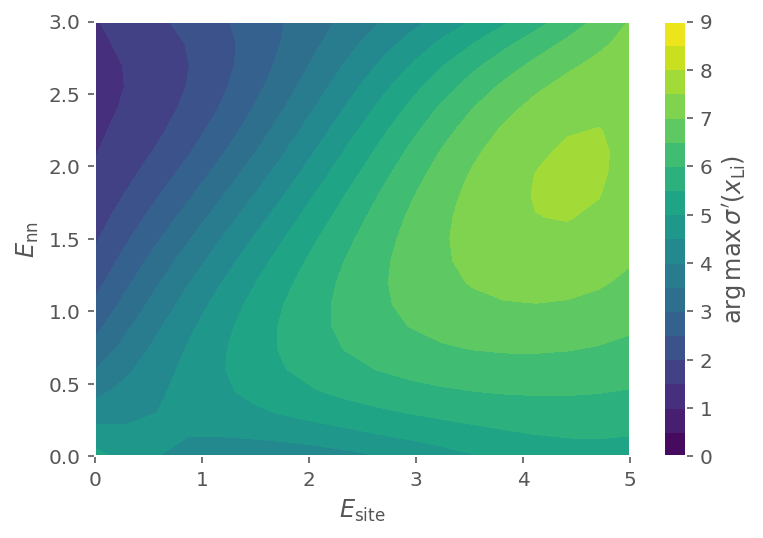

In [15]:
def func( group ):
    return group[ group.sigma_eff == group.sigma_eff.max() ]

ndata_pd = data.groupby( [ 'E_nn', 'E_site' ] ).apply( func ).reset_index( drop = True )
Z = ndata_pd.n_Li.values
Y = ndata_pd.E_nn.values
X = ndata_pd.E_site.values

fig = plt.figure()
ax = fig.add_subplot(111)

xnew, ynew = np.mgrid[0:5.0:18j, 0:3.0:21j]
tck = interpolate.bisplrep( X, Y, Z, s=3 )
znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

levels = np.linspace( 0.0, 9.0, 19 )

x,y=np.meshgrid(X, Y)
ax.set_xlabel( r'$E_\mathrm{site}$' )
ax.set_ylabel( r'$E_\mathrm{nn}$' )

cs = plt.contourf(xnew, ynew, znew, interpolation = 'bicubic', levels = levels, cmap = 'viridis' )

cbar = plt.colorbar( cs )
cbar.ax.set_ylabel( r'$\arg\,\max\,\sigma^\prime(x_\mathrm{Li})$')
fig.savefig( filename = 'max_sigma.pdf' )

/Users/bjm42/.pyenv/versions/3.6.1/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: The required storage space exceeds the available storage space.
Probable causes: nxest or nyest too small or s is too small. (fp>s)
	kx,ky=3,3 nx,ny=9,9 m=42 fp=27.888212 s=3.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


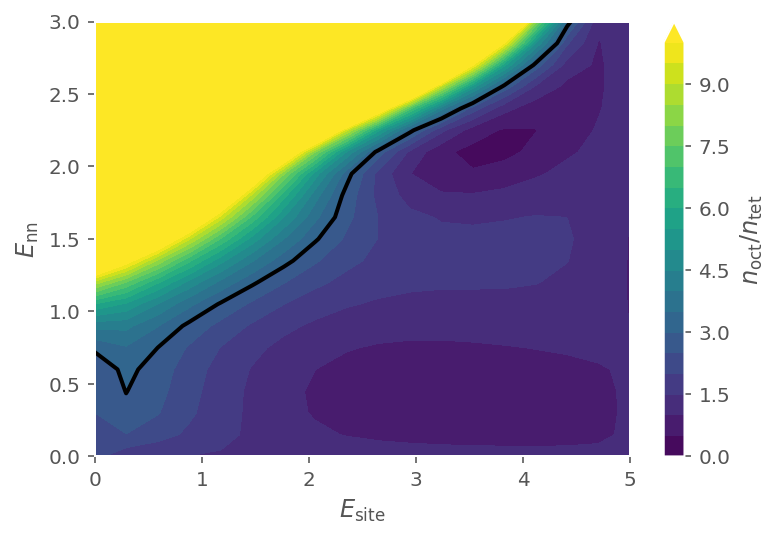

In [16]:
loc = data.n_Li == 6

Z = data[loc].site_ratio.values
Y = ndata_pd.E_nn.values
X = ndata_pd.E_site.values

fig = plt.figure()
ax = fig.add_subplot(111)

xnew, ynew = np.mgrid[0:5.0:18j, 0:3.0:21j]
tck = interpolate.bisplrep( X, Y, Z, s=3 )
znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

levels = np.linspace( 0.0, 10.0, 21 )

x,y=np.meshgrid(X, Y)
ax.set_xlabel( r'$E_\mathrm{site}$' )
ax.set_ylabel( r'$E_\mathrm{nn}$' )


cs = plt.contourf(xnew, ynew, znew, interpolation = 'bicubic', levels = levels, cmap = 'viridis', extend = 'max' )
CL = plt.contour(xnew, ynew, znew, levels = [ 3.0 ], linewidths=2, cmap = matplotlib.cm.gray )

cbar = plt.colorbar( cs )
cbar.ax.set_ylabel( r'$n_\mathrm{oct}/n_\mathrm{tet}$')
fig.savefig( filename = 'max_sigma.pdf' )

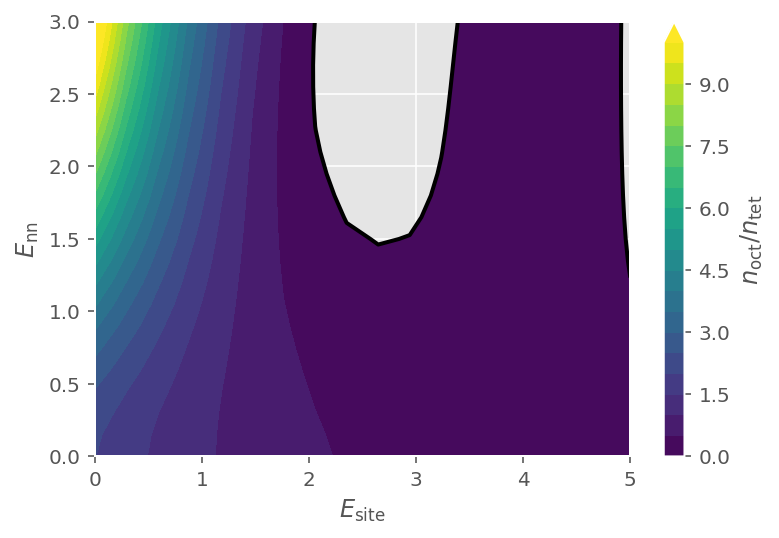

In [17]:
loc = data.n_Li == 3

Z = data[loc].site_ratio.values
Y = ndata_pd.E_nn.values
X = ndata_pd.E_site.values

fig = plt.figure()
ax = fig.add_subplot(111)

xnew, ynew = np.mgrid[0:5.0:18j, 0:3.0:21j]
tck = interpolate.bisplrep( X, Y, Z, s=3 )
znew2 = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

levels = np.linspace( 0.0, 10.0, 21 )

x,y=np.meshgrid(X, Y)
ax.set_xlabel( r'$E_\mathrm{site}$' )
ax.set_ylabel( r'$E_\mathrm{nn}$' )


cs = plt.contourf(xnew, ynew, znew2, interpolation = 'bicubic', levels = levels, cmap = 'viridis', extend = 'max' )
CL = plt.contour(xnew, ynew, znew2, levels = [ 0.0 ], linewidths=2, cmap = matplotlib.cm.gray )

cbar = plt.colorbar( cs )
cbar.ax.set_ylabel( r'$n_\mathrm{oct}/n_\mathrm{tet}$')
fig.savefig( filename = 'max_sigma.pdf' )

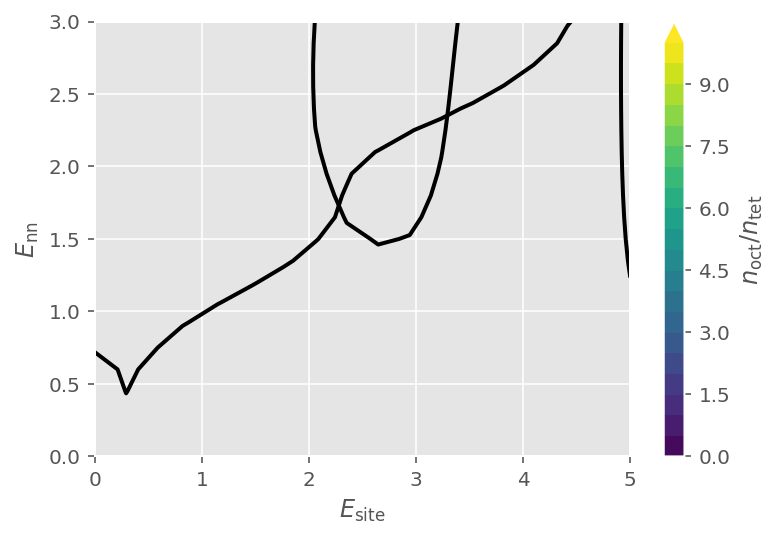

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

x,y=np.meshgrid(X, Y)
ax.set_xlabel( r'$E_\mathrm{site}$' )
ax.set_ylabel( r'$E_\mathrm{nn}$' )

# cs = plt.contourf(xnew, ynew, znew2, interpolation = 'bicubic', levels = levels, cmap = 'viridis', extend = 'max' )
CL1 = plt.contour(xnew, ynew, znew, levels = [ 3.0 ], linewidths=2, cmap = matplotlib.cm.gray )
CL2 = plt.contour(xnew, ynew, znew2, levels = [ 0.0 ], linewidths=2, cmap = matplotlib.cm.gray )

cbar = plt.colorbar( cs )
cbar.ax.set_ylabel( r'$n_\mathrm{oct}/n_\mathrm{tet}$')

In [19]:
plt.close('all')